In [25]:
import pandas as pd      # data preprocessing
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk              # feature engineering
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ML                     # model + evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
df = pd.read_excel("/content/ai_dev_assignment_tickets_complex_1000.xls")   # excel dataset
df.head()

,ticket_id,ticket_text,issue_type,urgency_level,product
0,1,Payment issue for my SmartWatch V2. I was unde...,Billing Problem,Medium,SmartWatch V2
1,2,Can you tell me more about the UltraClean Vacu...,General Inquiry,NaN,UltraClean Vacuum
2,3,I ordered SoundWave 300 but got EcoBreeze AC i...,Wrong Item,Medium,SoundWave 300
3,4,Facing installation issue with PhotoSnap Cam. ...,Installation Issue,Low,PhotoSnap Cam
4,5,Order #30903 for Vision LED TV is 13 days late...,Late Delivery,NaN,Vision LED TV


In [27]:
# Drop rows missing labels
df = df.dropna(subset=["ticket_text", "issue_type"]) # hard labels

# imputing missing urgency with mode~
df["urgency_level"] = df["urgency_level"].fillna(df["urgency_level"].mode()[0])


In [28]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()  # lowercase text
    text = re.sub(r"[^a-z\s]", " ", text)   # remove noise
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]  # lemmatisation
    return " ".join(tokens)

df["clean_text"] = df["ticket_text"].apply(clean_text)

# optimised specifically for tf idf andml models , we havent really used transformers

In [29]:
# numeric features added

df["text_length"] = df["ticket_text"].str.len()
df["word_count"] = df["ticket_text"].str.split().apply(len)

NUMERIC_FEATURES = ["text_length", "word_count"]

#adding lightweight num features would improves urgency prediction without really increasing model complexity

In [30]:
def make_preprocessor():
    return ColumnTransformer(
        transformers=[
            (                     # applies tf-idf ( tell how important a word is for the document)
                "text",
                TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
                "clean_text",
            ),
            ("num", "passthrough", NUMERIC_FEATURES),  # pass numeric features
        ]
    )
# also this pipeline can be rereused for different models and is

In [31]:
X = df[["clean_text", "text_length", "word_count"]]
y_issue = df["issue_type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_issue, test_size=0.2, stratify=y_issue, random_state=42
)

issue_model = Pipeline([
    ("features", make_preprocessor()),            # pipeline used here
    ("clf", LogisticRegression(max_iter=1000))    # logistic regression is used for better interpretability
])

issue_model.fit(X_train, y_train)

y_pred = issue_model.predict(X_test)
print(classification_report(y_test, y_pred))

# logistic regression is actually a strong basleine for tf idf data

# we have perfect generalisation over the dataset

                    precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        28
   Billing Problem       1.00      1.00      1.00        27
   General Inquiry       1.00      1.00      1.00        27
Installation Issue       1.00      1.00      1.00        27
     Late Delivery       1.00      1.00      1.00        21
    Product Defect       1.00      1.00      1.00        23
        Wrong Item       1.00      1.00      1.00        22

          accuracy                           1.00       175
         macro avg       1.00      1.00      1.00       175
      weighted avg       1.00      1.00      1.00       175



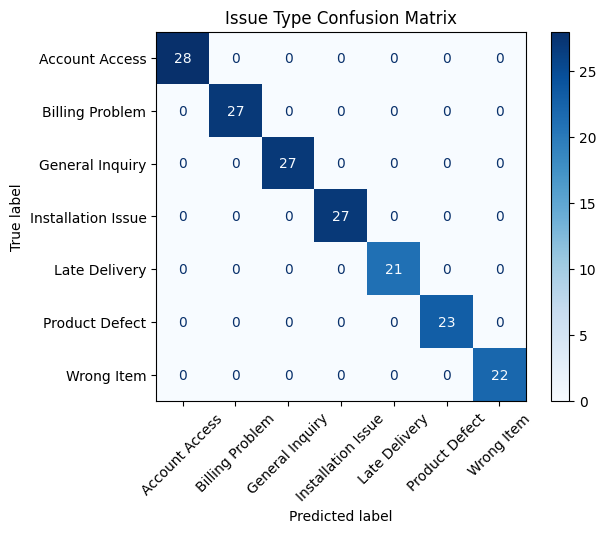

In [32]:
ConfusionMatrixDisplay.from_estimator(
    issue_model, X_test, y_test, cmap="Blues", xticks_rotation=45
)
plt.title("Issue Type Confusion Matrix")
plt.show()

# perfect confusion matrix


In [33]:
cv_scores = cross_val_score(
    issue_model, X, y_issue, cv=5, scoring="f1_macro"
)   # 5 folds

print("Cross-Validation F1 Scores:", cv_scores)
print("Mean F1 Score:", cv_scores.mean())


# perfect scores , third fold has a drop but it is still extremely high

Cross-Validation F1 Scores: [1.         1.         0.99479832 1.         1.        ]
Mean F1 Score: 0.9989596633092164


In [34]:
y_urgency = df["urgency_level"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_urgency, test_size=0.2, stratify=y_urgency, random_state=42
)

urgency_model = Pipeline([
    ("features", make_preprocessor()),   # pipeline used again
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))   # trees captures interactions better for non-linear data
])

urgency_model.fit(X_train, y_train)

y_pred = urgency_model.predict(X_test)
print(classification_report(y_test, y_pred))


# NOTE : i used logistic first but it didnt turn out to be good, then i used random forest as it has trees , didnt work out that well but still better
# also used xgboost with early stopping , it only increased the accuracy , recall remained the same
# Final choice is to use transformer embeddings ( BERT) instead of TF-IDF to better capture subtle language nuances.



              precision    recall  f1-score   support

        High       0.38      0.45      0.41        67
         Low       0.29      0.31      0.30        52
      Medium       0.34      0.25      0.29        56

    accuracy                           0.34       175
   macro avg       0.34      0.34      0.33       175
weighted avg       0.34      0.34      0.34       175



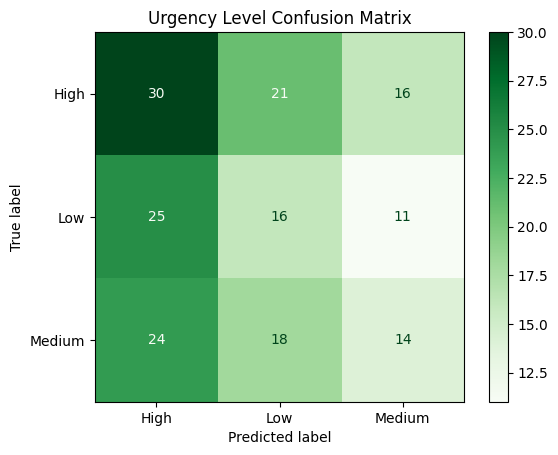

In [35]:
ConfusionMatrixDisplay.from_estimator(
    urgency_model, X_test, y_test, cmap="Greens"
)
plt.title("Urgency Level Confusion Matrix")
plt.show()

# passable

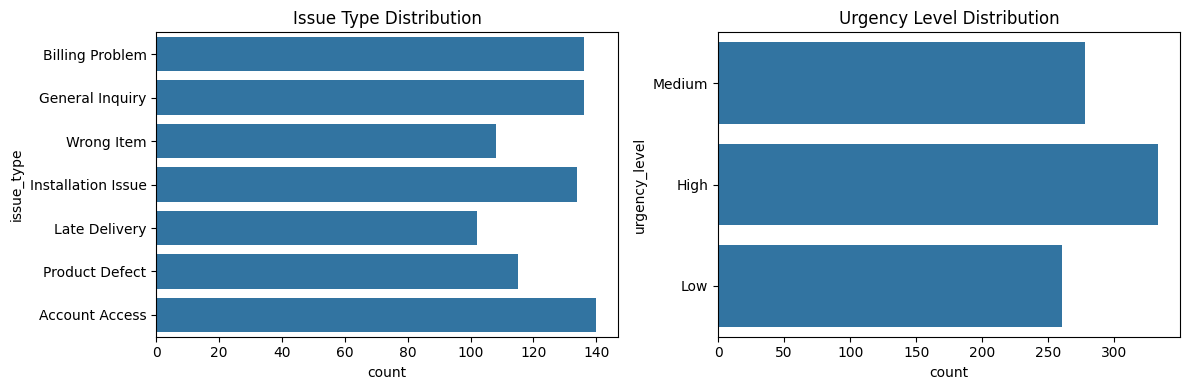

In [36]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.countplot(y=df["issue_type"])
plt.title("Issue Type Distribution")

plt.subplot(1, 2, 2)
sns.countplot(y=df["urgency_level"])
plt.title("Urgency Level Distribution")

plt.tight_layout()
plt.show()


# shows the type distribution for both issue and urgency

In [37]:
product_list = df["product"].dropna().unique().tolist()

def extract_products(text):
    return [p for p in product_list if p.lower() in text.lower()]   #lookup based

def extract_dates(text):          # regex
    patterns = [
        r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b',      # 12/01/2024
        r'\b\d{1,2}\s(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\b',  # 19 May
        r'\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s\d{1,2}\b'    # May 19
    ]

    dates = []
    for pattern in patterns:
        dates.extend(re.findall(pattern, text, flags=re.IGNORECASE))

    return list(set(dates))

complaint_patterns = [
    "not working",
    "stopped working",
    "broken",
    "damaged",
    "late",
    "delay",
    "days late",
    "no response",                # domain list
    "not delivered",
    "failed",
    "error",
    "issue",
    "problem",
    "missing",
    "unresolved",
    "fails",
    "unknown"
]

def extract_complaints(text):
    text = text.lower()
    found = []

    for pattern in complaint_patterns:
        if pattern in text:
            found.append(pattern)

    return found

# used rule-based entity extraction to complement ml predictions without overfitting
# as it is deterministic and explainable

In [38]:
def process_ticket(ticket_text):
    temp_df = pd.DataFrame({
        "clean_text": [clean_text(ticket_text)],
        "text_length": [len(ticket_text)],          # applies cleaning
        "word_count": [len(ticket_text.split())],
    })

    issue = issue_model.predict(temp_df)[0]              # uses the models we have made and stores them
    urgency = urgency_model.predict(temp_df)[0]

    return {
        "issue_type": issue,
        "urgency_level": urgency,                               # extract entities as json output
        "entities": {
            "products": extract_products(ticket_text),
            "dates": extract_dates(ticket_text),
            "complaint_keywords": extract_complaints(ticket_text),
        },
    }
# this function abstracts the full ML workflow into a single callable unit

In [39]:
sample_text = "My SmartWatch V2 stopped working on 12/01/2024 and the issue is unresolved"
process_ticket(sample_text)

 # testing out whole ml workflow

{'issue_type': 'Product Defect',
 'urgency_level': 'High',
 'entities': {'products': ['SmartWatch V2'],
  'dates': ['12/01/2024'],
  'complaint_keywords': ['stopped working', 'issue', 'unresolved']}}

In [40]:
import gradio as gr
import pandas as pd
import re

# Load trained models and helpers
# Assumes issue_model, urgency_model, clean_text, and entity functions are already defined
# If using notebooks, run training cells first

def predict_ticket(ticket_text):
    if not ticket_text.strip():
        return "❌ Empty input", "❌ Empty input", {}

    temp_df = pd.DataFrame({
        "clean_text": [clean_text(ticket_text)],
        "text_length": [len(ticket_text)],
        "word_count": [len(ticket_text.split())]
    })

    issue = issue_model.predict(temp_df)[0]
    urgency = urgency_model.predict(temp_df)[0]

    entities = {
        "products": extract_products(ticket_text),
        "dates": extract_dates(ticket_text),
        "complaint_keywords": extract_complaints(ticket_text)
    }

    return issue, urgency, entities


In [41]:
with gr.Blocks(title="Customer Support Ticket Classifier") as demo:

    gr.Markdown("""
    # 🧾 Customer Support Ticket Analyzer
    **Issue Classification • Urgency Detection • Entity Extraction**
    """)

    ticket_input = gr.Textbox(
        label="Enter Customer Support Ticket",
        placeholder="e.g. My SmartWatch V2 stopped working on 12/01/2024",
        lines=4
    )

    analyze_button = gr.Button("Analyze Ticket 😎")

    issue_output = gr.Textbox(label="Predicted Issue Type")
    urgency_output = gr.Textbox(label="Predicted Urgency Level")
    entity_output = gr.JSON(label="Extracted Entities")

    analyze_button.click(
        fn=predict_ticket,
        inputs=ticket_input,
        outputs=[issue_output, urgency_output, entity_output]
    )

demo.launch(
    debug=True,
    share=False
)


IMPORTANT: You are using gradio version 3.50.2, however version 4.44.1 is available, please upgrade.
--------
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.
